In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as lines
%matplotlib notebook

In [2]:
def chess_board(x,y, fields_in_row = 6):
    """ generate chessbord
    
    Args:
        x,y: position 0<=x,y<=1
        fields_in_row (int): number of chess field per row and column       

    Returns: 0 or 1 depending on whether the position in black or white
    """
    return (fields_in_row*x % 2 > 1) ^ (fields_in_row*y % 2 > 1)

In [3]:
def gen_batch(batch_size):
    """ creates new random batch """
    x = np.random.random([batch_size,2])
    y = [[1.*chess_board(*pos)] for pos in x]
    return x,y

<IPython.core.display.Javascript object>


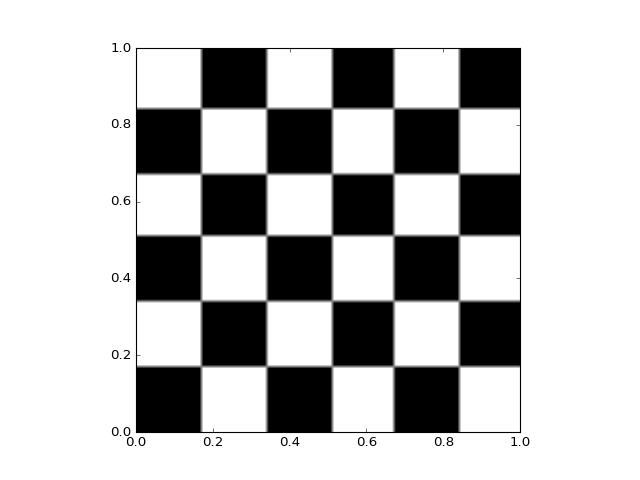

In [4]:
def draw_board_lattice():
    x_show = np.array(np.meshgrid(np.linspace(0,1,100,endpoint = False),np.linspace(0,1,100,endpoint = False))).reshape(2,-1).transpose()   
    y = np.array([chess_board(*x) for x in x_show]).reshape(100,100)
    plt.imshow(y,origin='lower',
        cmap=cm.gray, extent=(0, 1, 0, 1))
    
draw_board_lattice()
plt.show()

In [5]:
sess = tf.InteractiveSession()

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 2])
y_ = tf.placeholder(tf.float32, shape=[None, 1]) #the ground truth

In [7]:
N_h1 = 15
N_h2 = 15

W_h1 = tf.Variable(tf.truncated_normal([2,N_h1], stddev=0.1))
b_h1 = tf.Variable(tf.constant(0.1, shape=[N_h1]))
h1 = tf.nn.sigmoid(tf.matmul(x, W_h1) + b_h1)

W_h2 = tf.Variable(tf.truncated_normal([N_h1,N_h2], stddev=0.1))
b_h2 = tf.Variable(tf.constant(0.1, shape=[N_h2]))
h2 = tf.nn.sigmoid(tf.matmul(h1, W_h2) + b_h2)

W_out = tf.Variable(tf.random_normal([N_h2,1]))
b_out = tf.Variable(tf.zeros([1]))
y = tf.nn.sigmoid(tf.matmul(h2, W_out) + b_out)

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y+10**-6) + (1-y_) * tf.log(1-y+10**-6), 
    reduction_indices=[1]))
correct_prediction = tf.equal(tf.greater(y,0.5)[:,0], tf.greater(y_,0.5)[:,0])
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#train_step = tf.train.GradientDescentOptimizer(.5).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
#train_step = tf.train.MomentumOptimizer(0.04, 0.9).minimize(cross_entropy)
tf.initialize_all_variables().run()

In [9]:
def draw_board(x,y):
    plt.plot(x[y][:,0],x[y][:,1],'r.')
    plt.plot(x[y==False][:,0],x[y==False][:,1],'g.')
    
def show_prediction(length):
    x_test = np.random.random([length,2])
    tmp = sess.run(y, {x: x_test})
    classification = np.array([t[0] > 0.5 for t in tmp])
    draw_board(x_test, classification)
    plt.show()

<IPython.core.display.Javascript object>


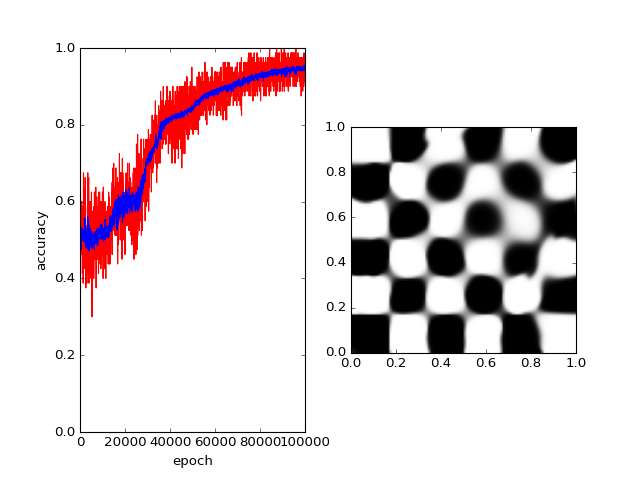

In [10]:
epoch_num = 10**5
batch_size = 80
logging_loss_train = []
logging_accuracy_train = []
logging_accuracy_test = []
logging_epoch = []

fig,axes = plt.subplots(1,2)
ax_logging = axes[0]
ax_board = axes[1]

ax_logging.set_xlabel('epoch')
ax_logging.set_ylabel('accuracy')
ax_logging.set_xlim(0,epoch_num)
ax_logging.set_ylim(0,1)
line_accuracy_train = lines.Line2D([], [], color = 'r')
line_accuracy_test = lines.Line2D([], [], color = 'b')
ax_logging.add_line(line_accuracy_train)
ax_logging.add_line(line_accuracy_test)
ax_board.set_xlim(0,1)
ax_board.set_ylim(0,1)
line_board_white = lines.Line2D([], [], color = 'r')
line_board_black = lines.Line2D([], [], color = 'g')
ax_board.add_line(line_board_white)
ax_board.add_line(line_board_black)
img = plt.imshow(np.zeros((2,2)),origin='lower',
        cmap=cm.gray, extent=(0, 1, 0, 1))
img.norm.vmin = 0
img.norm.vmax = 1

plt.show()

for epoch in range(epoch_num):
    batch = gen_batch(batch_size)
    feed_dict = {x: batch[0], y_: batch[1]}
    train_step.run(feed_dict = feed_dict)
    if epoch%(epoch_num //2000) == 0:
        train_loss = cross_entropy.eval(feed_dict = feed_dict)
        train_accuracy = accuracy.eval(feed_dict = feed_dict)
        batch_test_x = np.array(np.meshgrid(np.linspace(0,1,100,endpoint = False),np.linspace(0,1,100,endpoint = False))).reshape(2,-1).transpose() 
        batch_test_y_ = np.array([[chess_board(*x)] for x in batch_test_x])
        feed_dict_test = {x: batch_test_x, y_: batch_test_y_}
        y_test = y.eval(feed_dict = feed_dict_test)  
        test_loss = cross_entropy.eval(feed_dict = feed_dict_test)
        test_accuracy = accuracy.eval(feed_dict = feed_dict_test)
        logging_loss_train.append(train_loss) 
        logging_accuracy_train.append(train_accuracy)
        logging_accuracy_test.append(test_accuracy)
        logging_epoch.append(epoch)
                
        
        img.set_data(y_test.reshape(100,100))
        line_accuracy_train.set_xdata(logging_epoch)
        line_accuracy_train.set_ydata(logging_accuracy_train)
        line_accuracy_test.set_xdata(logging_epoch)
        line_accuracy_test.set_ydata(logging_accuracy_test)
        fig.canvas.draw()
        